In [1]:
import tensorflow as tf
import keras.backend as K
import numpy as np
import sklearn
from sklearn import model_selection
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import re
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import time
#drive.mount('/content/drive')

### Loading data and selecting subset of three classes

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Picking random 3 classes

random_classes = [0,1,5]

def sample_subset(X, y, random_classes=random_classes):

    def unison_shuffled_copies(a, b):
        '''This function is to shuffled two numpy arrays in unison'''
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    assert len(random_classes) == 3, 'Number of random classes must be three for this situation'

    class_x_tot = []
    class_y_tot = []
    for label in random_classes:
        class_x_tot.append(np.take(X, np.where(y==label)[0], axis=0))
        class_y_tot.append(np.take(y, np.where(y==label)[0], axis=0))
    
    X = np.concatenate((class_x_tot[0], class_x_tot[1], class_x_tot[2]))
    y = np.concatenate((class_y_tot[0], class_y_tot[1], class_y_tot[2]))

    X, y = unison_shuffled_copies(X, y)
    return X, y

#training set
x_train, y_train = sample_subset(x_train, y_train)

#testing set
x_test, y_test = sample_subset(x_test, y_test)

170508288/170498071 [==============================] - 14s 0us/step


### Splitting data into training, validation, and test sets

In [3]:
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_train, y_train, test_size = .20, random_state=1)

def shapes():
    print(f'X Train set: {np.shape(x_train)}\nY Train set: {np.shape(y_train)}\n\nX Val set: {np.shape(x_val)}\nY val set: {np.shape(y_val)}\n\nX Test set: {np.shape(x_test)}\nY Test set: {np.shape(y_test)}')

shapes()

X Train set: (12000, 32, 32, 3)
Y Train set: (12000, 1)

X Val set: (3000, 32, 32, 3)
Y val set: (3000, 1)

X Test set: (3000, 32, 32, 3)
Y Test set: (3000, 1)


### Vectorization
1. Take the mean of the color channel
2. Divide by 255 to normalize (this should reduce it down to 32, 32 solely)
3. Reshape array to go from 32 x 32 dimension to one dimension (32*32 = 1024) in length
4. Pass this in to the network with input_shape = (32 * 32)

In [4]:
def vectorize(arr):
    # take mean of color channels and normalize by dividing by 255.
    arr = np.mean(arr, axis=3) / 255.

    #reshape it to go from 2 dimensions (32 x 32) to one dimension of 1024 (32*32)
    arr = arr.reshape((len(arr), (np.shape(arr)[1] * np.shape(arr)[2])))

    #return arr
    return arr

# run the function vectorize over all the x data
print(f'---------------Shape before----------------')
shapes()

x_train = vectorize(x_train)
x_val = vectorize(x_val)
x_test = vectorize(x_test)
print(f'---------------Shape after----------------')
shapes()

---------------Shape before----------------
X Train set: (12000, 32, 32, 3)
Y Train set: (12000, 1)

X Val set: (3000, 32, 32, 3)
Y val set: (3000, 1)

X Test set: (3000, 32, 32, 3)
Y Test set: (3000, 1)
---------------Shape after----------------
X Train set: (12000, 1024)
Y Train set: (12000, 1)

X Val set: (3000, 1024)
Y val set: (3000, 1)

X Test set: (3000, 1024)
Y Test set: (3000, 1)


In [5]:
def vectorize_y(arr):
    '''Prepares labels for training'''
    # Need to change the labels from 0,1,5 to 0,1,2 to ensure proper categorical encoding
    arr[arr==5]=2

    #now utilize to_categorical and return it
    return tf.keras.utils.to_categorical(arr)

print(f'---------------Shape before----------------')
shapes()

y_val = vectorize_y(y_val)
y_test = vectorize_y(y_test)
y_train = vectorize_y(y_train)
print(f'---------------Shape after----------------')
shapes()

---------------Shape before----------------
X Train set: (12000, 1024)
Y Train set: (12000, 1)

X Val set: (3000, 1024)
Y val set: (3000, 1)

X Test set: (3000, 1024)
Y Test set: (3000, 1)
---------------Shape after----------------
X Train set: (12000, 1024)
Y Train set: (12000, 3)

X Val set: (3000, 1024)
Y val set: (3000, 3)

X Test set: (3000, 1024)
Y Test set: (3000, 3)


### Building the model

In [6]:
def model_functional():
    inputs=tf.keras.Input(shape=(32*32,), name="images vectorized")

    x = tf.keras.layers.Dense(512, activation='sigmoid')(inputs)

    x = tf.keras.layers.Dense(256, activation='sigmoid')(x)

    #out = tf.keras.layers.Dense(3, name='outputs')(x)
    out = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=out)

    return model


In [7]:
model = model_functional()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images vectorized (InputLay  [(None, 1024)]           0         
 er)                                                             
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 outputs (Dense)             (None, 3)                 771       
                                                                 
Total params: 656,899
Trainable params: 656,899
Non-trainable params: 0
_________________________________________________________________


In [8]:
#instantiate optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

#loss fn
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

### Training Loop

IGNORE THE FOLLOWING CELL

In [15]:
# def train_model_2(model, batch_size, epochs, x_train, y_train, x_val, y_val):
#     train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#     train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size=batch_size)

#     val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#     val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size=batch_size)

#     train_acc_metric = tf.keras.metrics.CategoricalAccuracy
#     val_acc_metric = tf.keras.metrics.CategoricalAccuracy

#     #instantiate optimizer
#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

#     #loss fn
#     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#     @tf.function
#     def train_step(x, y):
#         with tf.GradientTape() as tape:
#             logits = model(x, training=True)
#             loss_value = loss_fn(y, logits)
#         grads = tape.gradient(loss_value, model.trainable_weights)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights))
#         train_acc_metric.update_state(y, logits)
#         return loss_value

#     @tf.function
#     def test_step(x, y):
#         val_logits = model(x, training=False)
#         val_acc_metric.update_state(y, val_logits)


#     for epoch in range(epochs):
#         print("\nStart of epoch %d" % (epoch,))
#         start_time = time.time()

#         # Iterate over the batches of the dataset.
#         for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
#             loss_value = train_step(x_batch_train, y_batch_train)

#             # Log every 200 batches.
#             if step % 200 == 0:
#                 print(
#                     "Training loss (for one batch) at step %d: %.4f"
#                     % (step, float(loss_value))
#                 )
#                 print("Seen so far: %d samples" % ((step + 1) * batch_size))

#         # Display metrics at the end of each epoch.
#         train_acc = train_acc_metric.result()
#         print("Training acc over epoch: %.4f" % (float(train_acc),))

#         # Reset training metrics at the end of each epoch
#         train_acc_metric.reset_states()

#         # Run a validation loop at the end of each epoch.
#         for x_batch_val, y_batch_val in val_dataset:
#             test_step(x_batch_val, y_batch_val)

#         val_acc = val_acc_metric.result()
#         val_acc_metric.reset_states()
#         print("Validation acc: %.4f" % (float(val_acc),))
#         print("Time taken: %.2fs" % (time.time() - start_time))
        
# train_model_2(model=model, batch_size=64, epochs=5, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

In [11]:
def train_model(model, batch_size, epochs, x_train, y_train, x_val, y_val):

    #formulate the proper dataset using tensorflow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size=batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size=batch_size)

    #categorical accuracy since we're using categorical cross entropy as our loss function and it's a multi-class
    #classification case
    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

    #instantiate 4 empty vectors which will be used to track certain metrics
    train_acc_vec = []
    train_loss_vec = []
    val_acc_vec = []
    val_loss_vec = []

    #instantiate optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    #loss fn
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    # ignore -------------------------------------------------------------------
    # @tf.function
    # def train_step(x, y):
    #     with tf.GradientTape() as tape:
    #         logits = model(x, training=True)
    #         loss_value = loss_fn(y, logits)
    #     grads = tape.gradient(loss_value, model.trainable_weights)
    #     optimizer.apply_gradients(zip(grads, model.trainable_weights))
    #     train_acc_metric.update_state(y, logits)
    #     return loss_value

    # @tf.function
    # def test_step(x, y):
    #     val_logits = model(x, training=False)
    #     val_acc_metric.update_state(y, val_logits)
    # ignore -------------------------------------------------------------------
    for epoch in range(epochs):
        print(f'~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print(f'Currently on epoch: {epoch}')

        start_time = time.time()
        #iterate over batches
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = loss(y_batch_train, logits)
            #get gradients
            grads = tape.gradient(loss_value, model.trainable_variables)
            #adjust the model weights respectively using the designated optimizer
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        #update the training acc metric
        train_acc_metric.update_state(y_batch_train, logits)

        #display the training result
        train_acc = train_acc_metric.result()
        print(' ')
        print(f'Training accuracy over current epoch: {float(train_acc)}')
        train_acc_vec.append(train_acc)
        train_loss_current_epoch = loss(y_batch_train, logits)
        train_loss_vec.append(train_loss_current_epoch)

        print(f'Training loss over current epoch: {float(train_loss_current_epoch)}')
        print(' ')
        #Reset training acc state
        train_acc_metric.reset_states()


        #Run a validation loop at the end of each epoch
        for x_batch_val, y_batch_val in val_dataset:

            temp_vec = [] #used to take the mean of the val loss
            #get logits
            val_logits = model(x_batch_val, training=False)
            #update val accuracy metric
            val_acc_metric.update_state(y_batch_val, val_logits)
            
            val_loss = loss(y_batch_val, val_logits) #calcualte the val loss for the current batch

            temp_vec.append(val_loss) #append it to temp vec
        
        val_loss_vec.append(np.mean(temp_vec)) #once its done processing all the batches, append the mean of temp_vec to val_loss_vec
        val_acc = val_acc_metric.result()
        val_acc_vec.append(val_acc)

        print(f'Validation accuracy over current epoch: {float(val_acc)}')
        print(f'Validation loss over current epoch: {val_loss_vec[-1]}')
        print("Time taken: %.2fs" % (time.time() - start_time))
        #reset val metric state
        val_acc_metric.reset_states()

    return train_acc_vec, train_loss_vec, val_acc_vec, val_loss_vec

In [12]:
train_acc_vec, train_loss_vec, val_acc_vec, val_loss_vec = train_model(model=model, batch_size=64, epochs=55, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

~~~~~~~~~~~~~~~~~~~~~~~~~~~
Currently on epoch: 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 
Training accuracy over current epoch: 0.625
Training loss over current epoch: 0.8880450129508972
 
Validation accuracy over current epoch: 0.6269999742507935
Validation loss over current epoch: 0.8387905955314636
Time taken: 6.05s
~~~~~~~~~~~~~~~~~~~~~~~~~~~
Currently on epoch: 1
 
Training accuracy over current epoch: 0.71875
Training loss over current epoch: 0.6014516353607178
 
Validation accuracy over current epoch: 0.6610000133514404
Validation loss over current epoch: 0.8246899843215942
Time taken: 2.47s
~~~~~~~~~~~~~~~~~~~~~~~~~~~
Currently on epoch: 2
 
Training accuracy over current epoch: 0.59375
Training loss over current epoch: 0.8446187973022461
 
Validation accuracy over current epoch: 0.690666675567627
Validation loss over current epoch: 0.6360421180725098
Time taken: 5.45s
~~~~~~~~~~~~~~~~~~~~~~~~~~~
Currently on epoch: 3
 
Training accuracy over current epoch: 0.65625
Training loss over current epoch: 0.7499500513076782
 
Validation accuracy over current epoch: 0.718

### Plotting to observe model performance during training

In [13]:
def gen_plots(train_acc, train_loss, val_acc, val_loss):
    #accuracy
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

    # loss
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

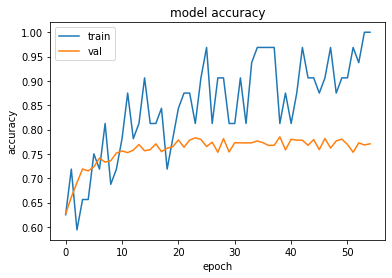

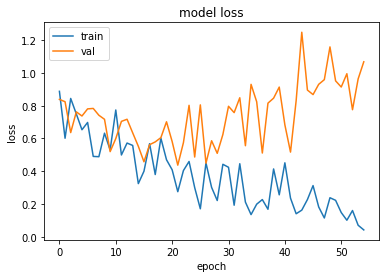

In [14]:
gen_plots(train_acc_vec, train_loss_vec, val_acc_vec, val_loss_vec)